In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.DataFrame(columns=['numLstmLayers', 'hidden_sizes', 'iteration', 'test_accuracy', 'conv'])
for root, dirs, files in os.walk('./logs'):
    for dir in dirs:
        if dir.startswith('custom_LSTM'):
            numLstmLayers = dir.split('_')[8]
            hidden_sizes = dir.split('_')[11]
            iteration = dir.split('_')[-1]
            if 'True' in dir:
                conv = True
            else:
                conv = False
            with open(f'{root}/{dir}/data.json') as f:
                data = json.load(f)
            test_accuracy = data['test_accuracy']
            df = pd.concat([df, pd.DataFrame([[numLstmLayers, hidden_sizes, iteration, test_accuracy, conv]], columns=['numLstmLayers', 'hidden_sizes', 'iteration', 'test_accuracy', 'conv'])], ignore_index=True)
df = df.reset_index(drop=True)

C:\Users\szymo\AppData\Local\Temp\ipykernel_10400\2915922131.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, pd.DataFrame([[numLstmLayers, hidden_sizes, iteration, test_accuracy, conv]], columns=['numLstmLayers', 'hidden_sizes', 'iteration', 'test_accuracy', 'conv'])], ignore_index=True)
C:\Users\szymo\AppData\Local\Temp\ipykernel_10400\2915922131.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, pd.DataFrame([[numLstmLayers, hidden_sizes, iteration, test_accuracy, conv]], columns=['numLstmLayers', 'hidden_sizes', 'iteration', 'test_accuracy', 'conv'])], ignore_index=True)
C:\Users\szymo\AppData\Local\Temp\ipykernel_10400\2915922131.py:15: FutureWarning: In a future version, object-dty

In [3]:
df['numLstmLayers'] = df['numLstmLayers'].astype(int)
df['hidden_sizes'] = df['hidden_sizes'].astype(int)
df['iteration'] = df['iteration'].astype(int)
df['test_accuracy'] = df['test_accuracy'].astype(float)

In [4]:
df.head()

,numLstmLayers,hidden_sizes,iteration,test_accuracy,conv
0,2,32,0,0.855607,False
1,2,32,1,0.803379,False
2,2,32,2,0.835637,False
3,2,32,3,0.854071,False
4,2,32,4,0.850998,False


In [5]:
df_grouped = df.groupby(['numLstmLayers', 'hidden_sizes', 'conv']).agg({'test_accuracy': ['mean', 'std']}).reset_index()
df_grouped.columns = ['numLstmLayers', 'hidden_sizes', 'conv', 'test_accuracy_mean', 'test_accuracy_std']
df_grouped = df_grouped.sort_values(by='test_accuracy_mean', ascending=False)   

In [34]:
df_grouped['test_accuracy_mean'] = df_grouped['test_accuracy_mean'].round(3)
df_grouped['test_accuracy_std'] = df_grouped['test_accuracy_std'].round(3)

In [35]:
df_grouped

,numLstmLayers,hidden_sizes,conv,test_accuracy_mean,test_accuracy_std
22,10,128,False,0.845,0.012
0,2,32,False,0.840,0.022
1,2,32,True,0.840,0.022
21,10,64,True,0.840,0.022
20,10,64,False,0.840,0.022
19,10,32,True,0.840,0.022
18,10,32,False,0.840,0.022
17,6,128,True,0.840,0.022
16,6,128,False,0.840,0.022
15,6,64,True,0.840,0.022


## Plots

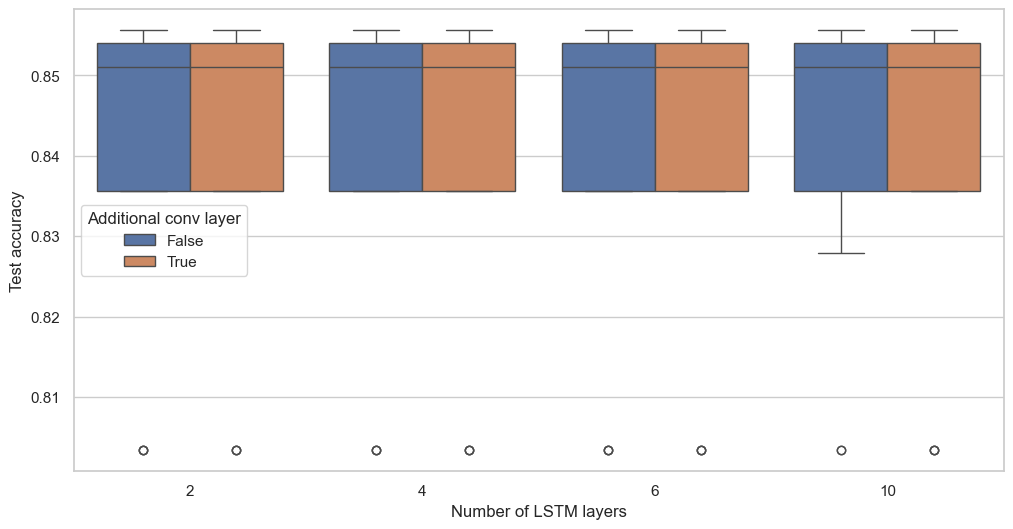

In [30]:
# boxplot of test accuracy with numLstmLayers on x and grouped by conv
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.boxplot(x='numLstmLayers', y='test_accuracy', hue='conv', data=df)
# plt.title('Test accuracy with number of LSTM layers')
# change legend title
plt.legend(title='Additional conv layer')
# change x axis label
plt.xlabel('Number of LSTM layers')
# change y axis label
plt.ylabel('Test accuracy')
# save the plot
plt.savefig('plots/lstm-numLstmLayers.png', bbox_inches='tight')
plt.show()


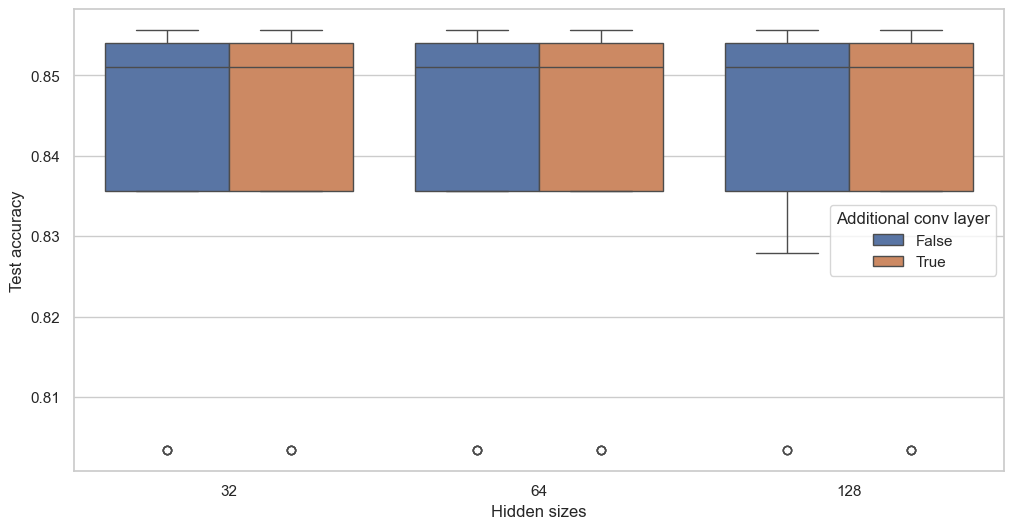

In [32]:
# boxplot of test accuracy with hidden_sizes on x and grouped by conv
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.boxplot(x='hidden_sizes', y='test_accuracy', hue='conv', data=df)
# plt.title('Test accuracy with hidden sizes')
# change legend title
plt.legend(title='Additional conv layer')
# change x axis label
plt.xlabel('Hidden sizes')
# change y axis label
plt.ylabel('Test accuracy')
# save the plot
plt.savefig('plots/lstm-hidden_sizes.png', bbox_inches='tight')
plt.show()

In [15]:
# best_model - best test accuracy from highest mean test accuracy
best_model = df_grouped.iloc[0]
numLstmLayers = best_model['numLstmLayers']
hidden_sizes = best_model['hidden_sizes']
conv = best_model['conv']
df_best = df[(df['numLstmLayers'] == numLstmLayers) & (df['hidden_sizes'] == hidden_sizes) & (df['conv'] == conv)]
df_best = df_best.sort_values(by='test_accuracy', ascending=False)
best_model = df_best.iloc[0]
best_model

numLstmLayers          10
hidden_sizes          128
iteration               0
test_accuracy    0.855607
conv                False
Name: 55, dtype: object

In [16]:
best_model_str = f'useConv_{conv}_numLstmLayers_{numLstmLayers}_hidden_sizes_{hidden_sizes}_{iteration}'
# search for the best model directory and open data.json
for root, dirs, files in os.walk('./logs'):
    for dir in dirs:
        if dir.startswith('custom_LSTM') and best_model_str in dir:
            with open(f'{root}/{dir}/data.json') as f:
                best_data = json.load(f)

In [19]:
predictions = best_data['predictions']
real_labels = best_data['real_labels']
label_to_index = best_data['label_to_index']

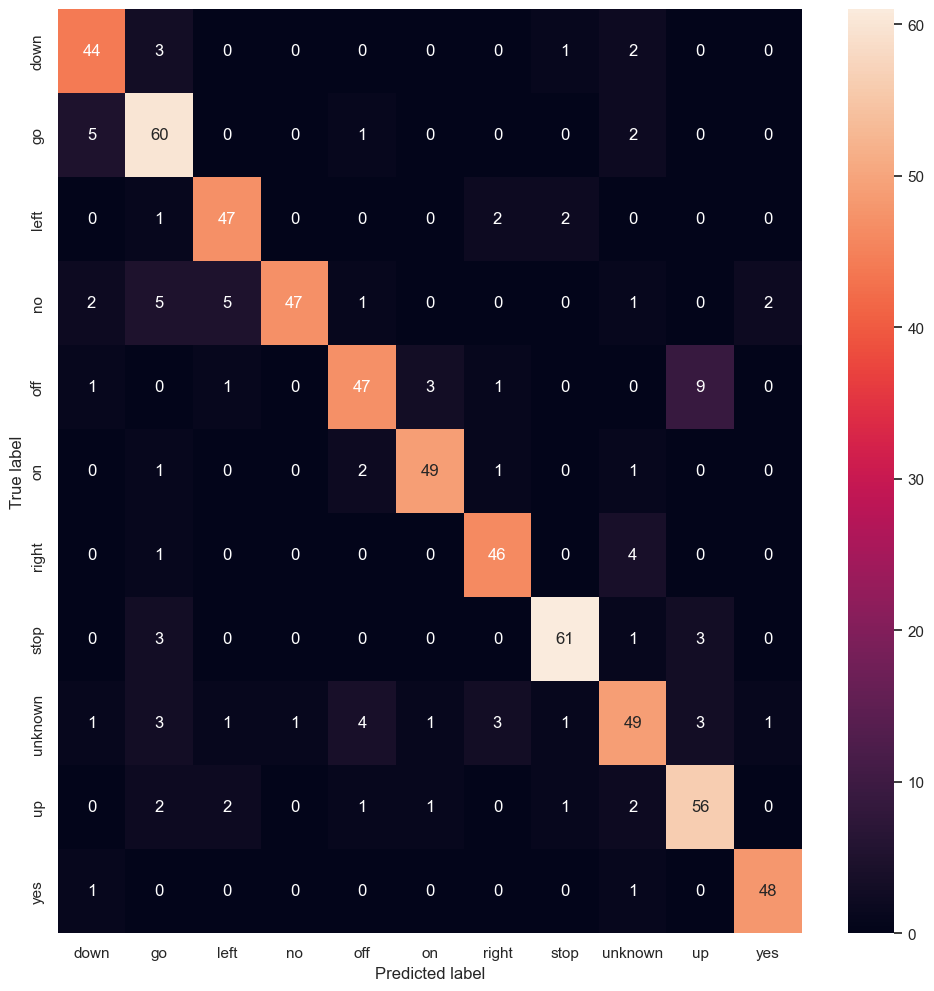

In [33]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(real_labels, predictions)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
# save the plot
plt.savefig('plots/lstm-confusion_matrix.png', bbox_inches='tight')
plt.show()

In [25]:
round(best_data['test_accuracy'], 3)

0.851